# Setting

In [1]:
from utility import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
#     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    
    return fs_data

In [4]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint

In [5]:
root = os.path.join(os.getcwd(), 'DATA')

# Import Data

In [6]:
df_train = pd.read_csv(os.path.join(root, 'preprocessed_train_notencoded.csv'))
df_exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))
df_oil = pd.read_csv(os.path.join(root, 'preprocessed_oil.csv'))
df_weather_kr = pd.read_csv(os.path.join(root, 'preprocessed_weather_korea.csv'))
df_cpi = pd.read_csv(os.path.join(root, 'preprocessed_cpi.csv'))
df_weather_with_wf = pd.read_csv(os.path.join(root, 'df_weather_with_wf.csv')) # 3-2 전처리 가설 검증 df_weather_with_wf

In [7]:
final_squid = pd.read_csv(os.path.join(root, 'final_squid.csv'))
final_salmon = pd.read_csv(os.path.join(root, 'final_salmon.csv'))
final_whiteleg_shrimp = pd.read_csv(os.path.join(root, 'final_whiteleg_shrimp.csv'))

# Best Model Selection

In [8]:
def model_scaler(data, col, scaler = None):
  
  '''
  정규화 함수
  data : dataframe
  column : P_PRICE
  scaler : standard, robust, minmax, log

  '''
 
  features = data.drop(col, axis=1)
  target = data[col]

  if scaler == 'standard':
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    return features, target

  elif scaler == 'robust':
    scaler = RobustScaler()
    features = scaler.fit_transform(features)

    return features, target

  elif scaler == 'minmax':
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    return features, target

  elif scaler == 'log':
    features = np.log1p(features)

    return features, target

  elif scaler == 'None':

    return features, target


################################################################################################################################################

def model_train(data, col, scaler, model = None):

  '''
  
  data : dataframe
  column : P_PRICE
  scaler : standard, robust, minmax, log
  model_name : linear, ridge, lasso, elastic, decisiontree,
               randomforest, ada, gradient, xgb, lgbm

  '''

  features, target = model_scaler(data, col, scaler)
  x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
  
  if model == 'linear': 
    
    model = LinearRegression()
    neg_mse_scores = cross_val_score(model, features, target, scoring = 'neg_mean_squared_error', cv = 10)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)


    print('RMSE : {:.4f}'.format(avg_rmse))

  elif model == 'ridge':
    
    params = {
              'alpha': (0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1, 1, 10, 100, 200, 50, 30, 20, 29, 58),            
              'fit_intercept':(True, False),
              'normalize':(True, False),

              }

    ridge = Ridge(random_state=0)
    final = RandomizedSearchCV(ridge, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 1000, n_jobs = -1 ,random_state=0)
    final.fit(x_train, y_train)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))
    
  elif model == 'lasso':

    params = {
              'alpha': (0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1, 1, 10, 100, 200, 50, 30, 20, 29, 58),            
              'fit_intercept':(True, False),
              'normalize':(True, False),

              }

    lasso = Lasso(random_state=0)
    final = RandomizedSearchCV(lasso, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 1000, n_jobs = -1 ,random_state=0)
    final.fit(features, target)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))
  
  elif model == 'elastic':
    

    params = {
       'alpha': (0.1, 0.01, 0.5, 1, 3, 5, 10),
       'l1_ratio':(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.1)
    }

    elastic = ElasticNet()
    final = RandomizedSearchCV(elastic, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 1000, n_jobs = -1 ,random_state=0)
    final.fit(features, target)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))
  elif model == 'decisiontree':
    
    params = {
              'max_depth': [1,3,5,7,9,15,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,550,600,700,800,900,1000,1100,1200,1500],            
               #'min_child_samples': randint(5, 50),
              'min_samples_split':[1,3,5,7,10,15,20,25,30,45,50,60,70,80,90,100],
              'min_samples_leaf': [1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              
    }

    dt = DecisionTreeRegressor(random_state=0)
    final = RandomizedSearchCV(dt, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 1000, n_jobs = -1 ,random_state=0)
    final.fit(features, target)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))
  elif model == 'randomforest':
    
    params = {
              'max_depth': [1,3,5,7,9,15,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,550,600,700,800,900,1000,1100,1200,1500],           
              'n_estimators':[1,5,10,30,50,70,100,200,500,750,1000],
               #'min_child_samples': randint(5, 50),
              'min_samples_leaf':[1,3,5,7,10,20,30,50,70,100],
              'min_samples_split': [1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'max_leaf_nodes': [1,3,5,7,10,20,30,50,70,100,200,500,700,800,900,1000],

              }

    rf = RandomForestRegressor(random_state=0)
    final = RandomizedSearchCV(rf, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)
    final.fit(features, target)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))


  elif model == 'gradinet':

    params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'subsample' : (0.01, 0.1, 0.5, 0.08, 0.35, 0.3, 0.001, 0.03, 0.006, 0.153, 0.193, 0.0012, 0.0083 ,1),
              'min_samples_split' : [1,3,5,7,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],
              'max_depth' : [1,3,5,7,9,15,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,550,600,700,800,900,1000,1100,1200,1500],  
              }   

    grad = GradientBoostingRegressor()
    final = RandomizedSearchCV(grad, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)
    final.fit(features, target)
    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))

  elif model == 'xgb':
    
    params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'max_depth' :  [1,3,5,7,9,15,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,550,600,700,800,900,1000,1100,1200,1500],  
              'min_child_weight' :[0,0.05,0.5,1,3,5,7,9,15,25,50,100,200,300,500,700],
              }   

    xgb = XGBRegressor()
    final = RandomizedSearchCV(xgb, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)
    final.fit(features, target)

    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))

  elif model == 'lgbm':
    params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'max_depth' : [1,3,5,7,9,15,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,550,600,700,800,900,1000,1100,1200,1500],  
              'min_child_weight' : [0,0.05,0.5,1,3,5,7,9,15,25,50,100,200,300,500,700],
              'num_leaves': [1,3,5,7,9,15,25,50,100,200,300,500,700],
              'min_child_samples':[1,3,5,7,9,15,25,50,100,200,300,500,700],  
              }   

    lgbm = LGBMRegressor()
    final = RandomizedSearchCV(lgbm, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)
    final.fit(features, target)

    pred = final.predict(x_test)

    print('Best Params:', final.best_params_)
    print('Best Score:', np.sqrt(-1 *final.best_score_))
    print('Predict RMSE:',(np.sqrt(mean_squared_error(y_test, pred))))

## Squid

In [9]:
model_train(final_squid,'P_PRICE','None','linear')

RMSE : 0.1486


In [10]:
model_train(final_squid,'P_PRICE','None','ridge')

Best Params: {'normalize': True, 'fit_intercept': True, 'alpha': 0.1}
Best Score: 0.1241381886360962
Predict RMSE: 0.1639517263883529


In [11]:
model_train(final_squid,'P_PRICE','None','lasso')

Best Params: {'normalize': True, 'fit_intercept': True, 'alpha': 0.0001}
Best Score: 0.15532022457052236
Predict RMSE: 0.16133538997861485


In [12]:
model_train(final_squid,'P_PRICE','None','elastic')

Best Params: {'l1_ratio': 0.0001, 'alpha': 0.01}
Best Score: 0.1944827356689971
Predict RMSE: 0.18025565195966337


In [13]:
model_train(final_squid,'P_PRICE','None','decisiontree')

Best Params: {'min_samples_split': 50, 'min_samples_leaf': 3, 'max_depth': 425}
Best Score: 0.17780786358653258
Predict RMSE: 0.15760461275592408


In [14]:
model_train(final_squid,'P_PRICE','None','randomforest')

Best Params: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 50, 'max_depth': 900}
Best Score: 0.18032697345788637
Predict RMSE: 0.0699367340991376


In [15]:
model_train(final_squid,'P_PRICE','None','gradinet')

Best Params: {'subsample': 1, 'n_estimators': 500, 'min_samples_split': 100, 'max_depth': 15, 'learning_rate': 0.1}
Best Score: 0.1732514284745461
Predict RMSE: 0.0023052260135100096


In [16]:
model_train(final_squid,'P_PRICE','None','xgb')

Best Params: {'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 200, 'learning_rate': 0.185}
Best Score: 0.1648591733399777
Predict RMSE: 0.010350721309960781


In [17]:
model_train(final_squid,'P_PRICE','None','lgbm')

Best Params: {'num_leaves': 9, 'n_estimators': 500, 'min_child_weight': 1, 'min_child_samples': 7, 'max_depth': 9, 'learning_rate': 0.351}
Best Score: 0.16505896351139068
Predict RMSE: 1.2885572218458289e-06


Score와 RMSE가 모두 좋은 xgb 모델을 최종 모델로 선택

## Salmon

In [18]:
model_train(final_salmon,'P_PRICE','None','linear')

RMSE : 0.0998


In [19]:
model_train(final_salmon,'P_PRICE','None','ridge')

Best Params: {'normalize': True, 'fit_intercept': False, 'alpha': 0.003}
Best Score: 0.0772006288733917
Predict RMSE: 0.09430904114790227


In [20]:
model_train(final_salmon,'P_PRICE','None','lasso')

Best Params: {'normalize': True, 'fit_intercept': True, 'alpha': 0.01}
Best Score: 0.08829866482950782
Predict RMSE: 0.09756407193707708


In [21]:
model_train(final_salmon,'P_PRICE','None','elastic')

Best Params: {'l1_ratio': 0.5, 'alpha': 0.5}
Best Score: 0.08829866482950782
Predict RMSE: 0.09756407193707708


In [22]:
model_train(final_salmon,'P_PRICE','None','decisiontree')

Best Params: {'min_samples_split': 50, 'min_samples_leaf': 100, 'max_depth': 425}
Best Score: 0.0882986648295078
Predict RMSE: 0.09880300758006161


In [23]:
model_train(final_salmon,'P_PRICE','None','randomforest')

Best Params: {'n_estimators': 70, 'min_samples_split': 15, 'min_samples_leaf': 70, 'max_leaf_nodes': 200, 'max_depth': 50}
Best Score: 0.08829604112969916
Predict RMSE: 0.09741355196009162


In [24]:
model_train(final_salmon,'P_PRICE','None','gradinet')

Best Params: {'subsample': 0.0012, 'n_estimators': 1000, 'min_samples_split': 5, 'max_depth': 700, 'learning_rate': 0.04}
Best Score: 0.08541652668146228
Predict RMSE: 0.0997669163817161


In [25]:
model_train(final_salmon,'P_PRICE','None','xgb')

Best Params: {'n_estimators': 70, 'min_child_weight': 5, 'max_depth': 700, 'learning_rate': 0.185}
Best Score: 0.08517667181494888
Predict RMSE: 0.005716698290262133


In [26]:
model_train(final_salmon,'P_PRICE','None','lgbm')

Best Params: {'num_leaves': 25, 'n_estimators': 100, 'min_child_weight': 200, 'min_child_samples': 500, 'max_depth': 600, 'learning_rate': 0.096}
Best Score: 0.08829866440492393
Predict RMSE: 0.09756407193060133


Score와 RMSE가 모두 좋은 xgb 모델을 최종 모델로 선택

## Whiteleg_shrimp

In [27]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','linear')

RMSE : 0.0687


In [28]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','ridge')

Best Params: {'normalize': True, 'fit_intercept': True, 'alpha': 0.1}
Best Score: 0.06443919236581382
Predict RMSE: 0.06161760814862004


In [29]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','lasso')

Best Params: {'normalize': True, 'fit_intercept': True, 'alpha': 0.0001}
Best Score: 0.06914659517879697
Predict RMSE: 0.05917313232884017


In [30]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','elastic')

Best Params: {'l1_ratio': 0.0001, 'alpha': 0.01}
Best Score: 0.07205404020474011
Predict RMSE: 0.058576775718354755


In [31]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','decisiontree')

Best Params: {'min_samples_split': 50, 'min_samples_leaf': 3, 'max_depth': 425}
Best Score: 0.06705365279951024
Predict RMSE: 0.046813587807867194


In [32]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','randomforest')

Best Params: {'n_estimators': 30, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_leaf_nodes': 1000, 'max_depth': 475}
Best Score: 0.06472608137688356
Predict RMSE: 0.03752316450932871


In [33]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','gradinet')

Best Params: {'subsample': 0.3, 'n_estimators': 200, 'min_samples_split': 35, 'max_depth': 1500, 'learning_rate': 0.008}
Best Score: 0.06829415435880659
Predict RMSE: 0.04700549015221643


In [34]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','xgb')

Best Params: {'n_estimators': 30, 'min_child_weight': 9, 'max_depth': 1200, 'learning_rate': 0.185}
Best Score: 0.07029520957723986
Predict RMSE: 0.024268749013228588


In [35]:
model_train(final_whiteleg_shrimp,'P_PRICE','None','lgbm')

Best Params: {'num_leaves': 3, 'n_estimators': 100, 'min_child_weight': 0.5, 'min_child_samples': 9, 'max_depth': 50, 'learning_rate': 0.01825}
Best Score: 0.06709909749993162
Predict RMSE: 0.05033368841873987


Score와 RMSE가 모두 좋은 xgb 모델을 최종 모델로 선택

## Best Model

### Squid

In [36]:
params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'max_depth' :  [1,3,5,7,9,15,25,50,100,200,300,400,450,500,550,700,800,900,1000],  
              'min_child_weight' :[0,0.05,0.5,1,3,5,7,9,15,25,50,100,200,300,500,700],
              }


xgb = XGBRegressor()
squid_final = RandomizedSearchCV(xgb, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)

features = final_squid.drop('P_PRICE',axis=1)
target = final_squid['P_PRICE']

squid_final.fit(features, target)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                   param_distributions={'learning_rate': (0.01, 0.0001, 0.003,
                                                          0.5, 0.04, 0.008,
                                    

### Salmon

In [37]:
params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'max_depth' :  [1,3,5,7,9,15,25,50,100,200,300,400,450,500,550,700,800,900,1000],  
              'min_child_weight' :[0,0.05,0.5,1,3,5,7,9,15,25,50,100,200,300,500,700],
              }   

xgb = XGBRegressor()
salmon_final = RandomizedSearchCV(xgb, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)

features = final_salmon.drop('P_PRICE',axis=1)
target = final_salmon['P_PRICE']

salmon_final.fit(features, target)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                   param_distributions={'learning_rate': (0.01, 0.0001, 0.003,
                                                          0.5, 0.04, 0.008,
                                    

### Whiteleg Shrimp

In [38]:
params = {'n_estimators' : [1,5,10,30,50,70,100,200,500,1000],
              'learning_rate' :(0.01, 0.0001, 0.003, 0.5, 0.04, 0.008, 0.001, 0.351, 0.096, 0.853, 0.185, 0.01825, 0.012385, 0.1),
              'max_depth' :  [1,3,5,7,9,15,25,50,100,200,300,400,450,500,550,700,800,900,1000],  
              'min_child_weight' :[0,0.05,0.5,1,3,5,7,9,15,25,50,100,200,300,500,700],
              }   

xgb = XGBRegressor()
whiteleg_shrimp_final = RandomizedSearchCV(xgb, param_distributions = params, cv = 10, scoring = 'neg_mean_squared_error', n_iter = 50, n_jobs = -1 ,random_state=0)

features = final_whiteleg_shrimp.drop('P_PRICE',axis=1)
target = final_whiteleg_shrimp['P_PRICE']

whiteleg_shrimp_final.fit(features, target)

RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100,...
                   param_distributions={'learning_rate': (0.01, 0.0001, 0.003,
                                                          0.5, 0.04, 0.008,
                                    

# Test

## Test Data

### Import Data

In [39]:
df_test = pd.read_excel(os.path.join(root, 'test.xlsx'))

### Preprocessing

In [40]:
# test data용 
def check_week(df):
    """
    dataframe에 sdate 과 edate 사이에 모든 데이터가 있는지 확인하는 함수
    :param df: 검사하고자 하는 dataframe (set_week 형태)
    :return: 데이터가 전체 존재하는지 여부
    """
    cnt = 0
    sdate = date(2020, 1, 6)  # start date
    edate = date(2020, 12, 28)  # end date
    delta = edate - sdate  # as timedelta
    mem = set()

    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")

In [41]:
set_week(df_test, 'REG_DATE')

In [42]:
check_week(df_test)

missing 0 values


#### Squid

In [43]:
df_test_squid = df_test[(df_test['P_NAME']=='오징어')]
                        
df_test_squid = df_test_squid[['CTRY_1','CTRY_2','P_PRICE','year','week']]

In [44]:
df_test_squid

,CTRY_1,CTRY_2,P_PRICE,year,week
15,중국,중국,2.706303,2020,2
16,중국,중국,1.940000,2020,2
39,페루,칠레,2.195883,2020,2
40,페루,칠레,1.922647,2020,2
41,페루,페루,2.855495,2020,2
...,...,...,...,...,...
9421,페루,페루,2.160000,2020,53
9422,페루,페루,2.910000,2020,53
9428,페루,페루,1.330000,2020,53
9433,중국,중국,2.090000,2020,53


##### Merge Features

In [45]:
df_test_squid_add = df_test_squid.copy()

In [46]:
df_test_squid_add = pd.merge(df_test_squid_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [47]:
df_test_squid_add = pd.merge(df_test_squid_add, df_weather_kr, how='left', on=['year', 'week'])

In [48]:
df_test_squid_add = pd.merge(df_test_squid_add, df_oil, how='left', on=['year', 'week'])

In [49]:
df_test_squid_add = pd.merge(df_test_squid_add, df_cpi, how='left', on=['year', 'week'])

In [50]:
df_test_squid_add = pd.merge(df_test_squid_add, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

##### Grouping

In [51]:
df_test_squid_add = df_test_squid_add.groupby(['year','week']).mean()

In [52]:
df_test_squid_add

P_PRICE      rain      wind  temperature   wind_kr  \
year week                                                        
2020 2     2.694026  2.334508  4.580242     4.488313  7.867857   
     3     2.933695  1.179414  6.072819     6.174096  6.480420   
     4     2.933224  2.820167  4.911688     9.491382  6.940714   
     5     2.573288  1.518147  6.221916     9.590110  7.460000   
     6     2.862543  2.513545  2.389049     5.281556  7.084828   
     7     3.181970       NaN       NaN          NaN  6.048299   
     8     2.915586  0.804412  2.495098     1.238725  6.817687   
     9     2.419078  1.349674  5.781683    12.274438  6.518571   
     10    3.053760  2.148545  4.057673     8.994839  6.115646   
     11    2.730568  2.740398  4.262200    12.367063  7.688060   
     12    2.741034  1.621507  5.606527    13.040114  6.956061   
     13    2.356233  4.103233  5.289415    12.476271  6.333333   
     14    1.916776  1.951040  7.107076    11.326485  6.220000   
     15    2.918297  1.944324  4.335562    11.864580  5.535036   
     16    2.510407  3.747986  5.647155    12.678085  5.881379   
     17    2.379347  3.672558  4.014639    13.027853  7.776871   
     18    2.474297  3.150138  4.038028    12.716427  5.254422   
     19    2.987682  4.794563  4.100456    13.246152  5.846259   
     20    3.100046  3.466295  3.641004    14.113674  4.636054   
     21    2.705007  4.969177  3.962577    13.611996  5.512500   
     22    2.870999  5.710442  2.231858    17.090796  3.394444   
     23    2.475941  4.915087  4.287475    14.195321  3.756250   
     24    2.593165  5.616413  4.380446    15.904049  4.043571   
     25    2.525424  5.339000  4.425688    15.828766  4.182857   
     26    2.757299  5.701161  3.604829    16.077802  4.015603   
     27    2.583430  5.934368  4.001298    15.684941  5.076429   
     28    2.660586  6.818647  3.907209    16.006415  4.008759   
     29    3.153054  4.285917  4.236957    14.096927  5.381119   
     30    2.732656  4.591213  3.997590    14.858073  5.104861   
     31    2.768075  4.508649  3.606900    15.303149  3.837410   
     32    3.183839  4.548225  3.738211    14.816050  6.268148   
     33    2.794052  4.806986  4.323685    13.078870  5.369697   
     34    2.691555  3.899670  3.984888    13.670188  3.171233   
     35    2.989593  5.103080  4.402385    13.617914  5.550350   
     36    2.614699  3.746289  2.953100    13.981413  7.022727   
     37    2.676716  3.616615  4.753326    12.264383  6.455039   
     38    2.710624  3.377480  6.071287    13.501855  3.923077   
     39    2.662821  2.491254  5.559139    13.129200  6.810274   
     40    2.296022  3.215333  4.726892    11.447853  4.302041   
     41    2.635848  2.437553  4.771168    11.621726  7.609524   
     42    2.386459  3.991869  6.447040    12.536480  5.853175   
     43    3.927671  3.002896  3.793782    12.957965  6.592063   
     44    2.797458  3.592683  2.451220    15.826829  5.188028   
     45    2.622524  1.432981  3.518267    11.833736  6.141259   
     46    2.766692  7.876789  5.541494    14.797297  4.904965   
     47    2.610570  2.837819  4.307734     8.556733  7.466429   
     48    2.724792  1.831098  2.481707     6.103659  7.173188   
     49    2.480262  0.986047  2.313953     3.597674  6.578723   
     50    2.898781  1.959756  2.707317     4.773171  5.648611   
     51    2.241298  1.652043  4.388575     7.141250  8.272109   
     52    2.601302  1.127660  3.148936     3.151064  5.842553   
     53    2.277500  1.843137  3.980392     1.245098  8.074658   

           temperature_kr  water_temp_kr        oil  cpi_total  cpi_fish  \
year week                                                                  
2020 2           8.473571      12.859854  60.836000     105.79    118.44   
     3           5.767832      12.366434  58.408333     105.79    118.44   
     4           8.267857      11.884286  56.718000     105.79    118.44   
     5           7.672143      11.654676  52.730000     105.79    1

##### Filling Missing Values

In [53]:
df_test_squid_add.isna().sum() # 결측값 존재

P_PRICE           0
rain              1
wind              1
temperature       1
wind_kr           0
temperature_kr    0
water_temp_kr     0
oil               0
cpi_total         0
cpi_fish          0
exchange          0
dtype: int64

In [54]:
df_test_squid_add.fillna(method='ffill',inplace=True)  # 전주 값으로 대치

In [55]:
df_test_squid_add.isna().sum() # 결측치 처리 완료

P_PRICE           0
rain              0
wind              0
temperature       0
wind_kr           0
temperature_kr    0
water_temp_kr     0
oil               0
cpi_total         0
cpi_fish          0
exchange          0
dtype: int64

##### Adding & Drop Features 

In [56]:
df_test_squid_add['temp_kr'] = (df_test_squid_add['temperature_kr'] + df_test_squid_add['water_temp_kr'] + df_test_squid_add['wind_kr']) / 3
df_test_squid_add['cpi'] = df_test_squid_add['cpi_fish'] / df_test_squid_add['cpi_total']

In [57]:
df_test_squid_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr','wind_kr' ,'cpi_total'], axis=1, inplace=True)

##### Final Test DF

In [58]:
final_test_squid = df_test_squid_add

In [59]:
final_test_squid

P_PRICE      rain      wind  temperature        oil  exchange  \
year week                                                                   
2020 2     2.694026  2.334508  4.580242     4.488313  60.836000  0.137910   
     3     2.933695  1.179414  6.072819     6.174096  58.408333  0.173614   
     4     2.933224  2.820167  4.911688     9.491382  56.718000  0.149049   
     5     2.573288  1.518147  6.221916     9.590110  52.730000  0.179170   
     6     2.862543  2.513545  2.389049     5.281556  50.348000  0.257825   
     7     3.181970  2.513545  2.389049     5.281556  51.085000  0.294600   
     8     2.915586  0.804412  2.495098     1.238725  52.940000  0.265280   
     9     2.419078  1.349674  5.781683    12.274438  48.382000  0.162456   
     10    3.053760  2.148545  4.057673     8.994839  45.578000  0.202963   
     11    2.730568  2.740398  4.262200    12.367063  32.340000  0.181779   
     12    2.741034  1.621507  5.606527    13.040114  24.734000  0.141757   
     13    2.356233  4.103233  5.289415    12.476271  23.194000  0.121584   
     14    1.916776  1.951040  7.107076    11.326485  22.908000  0.108282   
     15    2.918297  1.944324  4.335562    11.864580  24.390000  0.107728   
     16    2.510407  3.747986  5.647155    12.678085  20.106000  0.127328   
     17    2.379347  3.672558  4.014639    13.027853   3.920000  0.131803   
     18    2.474297  3.150138  4.038028    12.716427  15.760000  0.102957   
     19    2.987682  4.794563  4.100456    13.246152  23.446000  0.132115   
     20    3.100046  3.466295  3.641004    14.113674  26.440000  0.157785   
     21    2.705007  4.969177  3.962577    13.611996  32.980000  0.143742   
     22    2.870999  5.710442  2.231858    17.090796  34.056000  0.156922   
     23    2.475941  4.915087  4.287475    14.195321  37.300000  0.127664   
     24    2.593165  5.616413  4.380446    15.904049  37.866000  0.155039   
     25    2.525424  5.339000  4.425688    15.828766  38.410000  0.129512   
     26    2.757299  5.701161  3.604829    16.077802  39.210000  0.099416   
     27    2.583430  5.934368  4.001298    15.684941  39.944000  0.127604   
     28    2.660586  6.818647  3.907209    16.006415  40.464000  0.152781   
     29    3.153054  4.285917  4.236957    14.096927  40.586000  0.143289   
     30    2.732656  4.591213  3.997590    14.858073  41.406000  0.127446   
     31    2.768075  4.508649  3.606900    15.303149  40.820000  0.166417   
     32    3.183839  4.548225  3.738211    14.816050  41.614000  0.163958   
     33    2.794052  4.806986  4.323685    13.078870  42.094000  0.184571   
     34    2.691555  3.899670  3.984888    13.670188  42.726000  0.166619   
     35    2.989593  5.103080  4.402385    13.617914  43.074000  0.155252   
     36    2.614699  3.746289  2.953100    13.981413  41.128333  0.175420   
     37    2.676716  3.616615  4.753326    12.264383  37.728000  0.170967   
     38    2.710624  3.377480  6.071287    13.501855  39.556000  0.167938   
     39    2.662821  2.491254  5.559139    13.129200  39.880000  0.189565   
     40    2.296022  3.215333  4.726892    11.447853  39.176000  0.155822   
     41    2.635848  2.437553  4.771168    11.621726  40.326000  0.187734   
     42    2.386459  3.991869  6.447040    12.536480  40.502000  0.188411   
     43    3.927671  3.002896  3.793782    12.957965  40.562000  0.204674   
     44    2.797458  3.592683  2.451220    15.826829  37.496000  0.248789   
     45    2.622524  1.432981  3.518267    11.833736  37.910000  0.181215   
     46    2.766692  7.876789  5.541494    14.797297  40.870000  0.202393   
     47    2.610570  2.837819  4.307734     8.556733  41.696000  0.190701   
     48    2.724792  1.831098  2.481707     6.103659  44.838000  0.235400   
     49    2.480262  0.986047  2.313953     3.597674  45.414000  0.230150   
     50    2.898781  1.959756  2.707317     4.773171  46.046000  0.230787   
     51    2.241298  1.652043  4.388575     7.141250  47.978000  0.218381   
     52 

#### Salmon

In [60]:
df_test_salmon = df_test[(df_test['P_NAME']=='연어')]

df_test_salmon = df_test_salmon[['CTRY_1','CTRY_2','P_PRICE','year','week']]

In [61]:
df_test_salmon

,CTRY_1,CTRY_2,P_PRICE,year,week
22,영국,영국,13.710029,2020,2
37,노르웨이,노르웨이,28.500000,2020,2
94,노르웨이,노르웨이,12.199457,2020,2
195,노르웨이,노르웨이,16.335035,2020,2
196,노르웨이,노르웨이,14.756580,2020,2
...,...,...,...,...,...
9435,노르웨이,노르웨이,8.750000,2020,53
9448,노르웨이,노르웨이,29.740000,2020,53
9459,노르웨이,노르웨이,15.290000,2020,53
9471,노르웨이,노르웨이,14.260000,2020,53


##### Merge Features

In [62]:
df_test_salmon_add = df_test_salmon.copy()

In [63]:
df_test_salmon_add = pd.merge(df_test_salmon_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [64]:
df_test_salmon_add = pd.merge(df_test_salmon_add, df_weather_kr, how='left', on=['year', 'week'])

In [65]:
df_test_salmon_add = pd.merge(df_test_salmon_add, df_oil, how='left', on=['year', 'week'])

In [66]:
df_test_salmon_add = pd.merge(df_test_salmon_add, df_cpi, how='left', on=['year', 'week'])

In [67]:
df_test_salmon_add = pd.merge(df_test_salmon_add, df_exchange, how='left', on=['year', 'week','CTRY_2'])

##### Grouping

In [68]:
df_test_salmon_add = df_test_salmon_add.groupby(['year','week']).mean()

In [69]:
df_test_salmon_add

P_PRICE      rain       wind  temperature   wind_kr  \
year week                                                          
2020 2     16.445297  2.692562   7.074380     1.905372  7.867857   
     3     16.157032  2.125000   6.288793    -0.349569  6.480420   
     4     15.587532  2.182463   7.123134    -0.490299  6.940714   
     5     15.516672  1.572358   5.772358    -1.876829  7.460000   
     6     15.199548  2.724380   6.028926    -2.043802  7.084828   
     7     14.370685  1.870928   7.195198     1.894691  6.048299   
     8     14.214829  1.690226   7.349624    -0.184962  6.817687   
     9     14.908977  1.756667   5.105556    -4.196667  6.518571   
     10    15.735015  2.389055   5.467662    -1.223383  6.115646   
     11    15.187748  1.470787   6.400749    -2.719476  7.688060   
     12    14.145295  1.778125   6.473958    -2.197396  6.956061   
     13    13.489208  2.409589   7.123288    -0.349315  6.333333   
     14    13.619301  1.864981   6.634241    -1.487160  6.220000   
     15    15.218819  1.700424   6.622881     0.936017  5.535036   
     16    11.658406  1.695798   6.378151     2.167647  5.881379   
     17    13.589954  1.958000   5.700000     2.591333  7.776871   
     18    13.111355  1.271515   3.890909     2.509091  5.254422   
     19    12.730455  1.504891   5.744565     2.166848  5.846259   
     20    13.567672  1.602500   6.862500     2.125625  4.636054   
     21    13.489495  1.902564   5.196581     5.842735  5.512500   
     22    13.151124  0.806838   4.623932     6.235897  3.394444   
     23    14.514669  0.876190   4.142857     6.966667  3.756250   
     24    14.217324       NaN        NaN          NaN  4.043571   
     25    14.198088       NaN        NaN          NaN  4.182857   
     26    13.817135       NaN        NaN          NaN  4.015603   
     27    13.206237       NaN        NaN          NaN  5.076429   
     28    12.461764       NaN        NaN          NaN  4.008759   
     29    12.966390       NaN        NaN          NaN  5.381119   
     30    12.668468       NaN        NaN          NaN  5.104861   
     31    13.435402       NaN        NaN          NaN  3.837410   
     32    12.912128       NaN        NaN          NaN  6.268148   
     33    12.273049  1.915714   6.285714     7.325714  5.369697   
     34    12.613889  0.871875   5.812500     7.500000  3.171233   
     35    12.992737  2.359494   6.367089     8.022785  5.550350   
     36    13.157984  0.437500   3.812500     7.400000  7.022727   
     37    12.872135  2.075000   6.517857     7.991071  6.455039   
     38    12.448167  0.904167   9.875000     9.620833  3.923077   
     39    13.096831  0.927273   9.272727    10.263636  6.810274   
     40    13.453682  2.017073   7.146341     7.743902  4.302041   
     41    13.438290  0.468000   6.720000     8.480000  7.609524   
     42    12.692603  1.280000  10.000000     8.920000  5.853175   
     43    12.197477  1.848889   5.600000     9.942222  6.592063   
     44    17.808812  2.172727   7.409091    10.804545  5.188028   
     45    11.890140       NaN        NaN          NaN  6.141259   
     46    12.806517  1.135294   7.058824    11.100000  4.904965   
     47    12.517778  1.463636   7.363636    14.372727  7.466429   
     48    12.491715  1.345455   6.575758    11.518182  7.173188   
     49    13.577170  0.516667   8.666667     9.433333  6.578723   
     50    12.875634  3.168571   7.400000    11.660000  5.648611   
     51    12.526810  1.400000   8.437500    14.206250  8.272109   
     52    12.750241  0.733333   9.000000    16.466667  5.842553   
     53    13.635556       NaN        NaN          NaN  8.074658   

           temperature_kr  water_temp_kr        oil  cpi_total  cpi_fish  \
year week                                                                  
2020 2           8.473571      12.859854  60.836000     105.79    118.44   
     3           5.767832      12.366434  58.408333     105.79    118.44   
     4           8.267857      11.88

##### Filling Missing Values

In [70]:
df_test_salmon_add.isna().sum() # 결측값 존재

P_PRICE            0
rain              11
wind              11
temperature       11
wind_kr            0
temperature_kr     0
water_temp_kr      0
oil                0
cpi_total          0
cpi_fish           0
exchange           0
dtype: int64

In [71]:
df_test_salmon_add.fillna(method='ffill',inplace=True)  # 전주 값으로 대치

In [72]:
df_test_salmon_add.isna().sum() # 결측값 처리 완료

P_PRICE           0
rain              0
wind              0
temperature       0
wind_kr           0
temperature_kr    0
water_temp_kr     0
oil               0
cpi_total         0
cpi_fish          0
exchange          0
dtype: int64

##### Adding & Drop Features 

In [73]:
df_test_salmon_add['temp_kr'] = (df_test_salmon_add['temperature_kr'] + df_test_salmon_add['water_temp_kr'] + df_test_salmon_add['wind_kr']) / 3
df_test_salmon_add['cpi'] = df_test_salmon_add['cpi_fish'] / df_test_salmon_add['cpi_total'] 

In [74]:
df_test_salmon_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr','wind_kr', 'cpi_total'], axis=1, inplace=True)

##### Final Test DF

In [75]:
final_test_salmon = df_test_salmon_add

In [76]:
final_test_salmon

P_PRICE      rain       wind  temperature        oil  exchange  \
year week                                                                     
2020 2     16.445297  2.692562   7.074380     1.905372  60.836000  0.113700   
     3     16.157032  2.125000   6.288793    -0.349569  58.408333  0.112400   
     4     15.587532  2.182463   7.123134    -0.490299  56.718000  0.112000   
     5     15.516672  1.572358   5.772358    -1.876829  52.730000  0.109400   
     6     15.199548  2.724380   6.028926    -2.043802  50.348000  0.107700   
     7     14.370685  1.870928   7.195198     1.894691  51.085000  0.092408   
     8     14.214829  1.690226   7.349624    -0.184962  52.940000  0.108000   
     9     14.908977  1.756667   5.105556    -4.196667  48.382000  0.106800   
     10    15.735015  2.389055   5.467662    -1.223383  45.578000  0.107600   
     11    15.187748  1.470787   6.400749    -2.719476  32.340000  0.104400   
     12    14.145295  1.778125   6.473958    -2.197396  24.734000  0.097300   
     13    13.489208  2.409589   7.123288    -0.349315  23.194000  0.086200   
     14    13.619301  1.864981   6.634241    -1.487160  22.908000  0.094800   
     15    15.218819  1.700424   6.622881     0.936017  24.390000  0.095800   
     16    11.658406  1.695798   6.378151     2.167647  20.106000  0.096600   
     17    13.589954  1.958000   5.700000     2.591333   3.920000  0.095500   
     18    13.111355  1.271515   3.890909     2.509091  15.760000  0.095100   
     19    12.730455  1.504891   5.744565     2.166848  23.446000  0.096700   
     20    13.567672  1.602500   6.862500     2.125625  26.440000  0.096800   
     21    13.489495  1.902564   5.196581     5.842735  32.980000  0.099700   
     22    13.151124  0.806838   4.623932     6.235897  34.056000  0.099400   
     23    14.514669  0.876190   4.142857     6.966667  37.300000  0.103900   
     24    14.217324  0.876190   4.142857     6.966667  37.866000  0.108000   
     25    14.198088  0.876190   4.142857     6.966667  38.410000  0.104800   
     26    13.817135  0.876190   4.142857     6.966667  39.210000  0.104100   
     27    13.206237  0.876190   4.142857     6.966667  39.944000  0.103300   
     28    12.461764  0.876190   4.142857     6.966667  40.464000  0.106400   
     29    12.966390  0.876190   4.142857     6.966667  40.586000  0.105900   
     30    12.668468  0.876190   4.142857     6.966667  41.406000  0.108400   
     31    13.435402  0.876190   4.142857     6.966667  40.820000  0.109900   
     32    12.912128  0.876190   4.142857     6.966667  41.614000  0.109500   
     33    12.273049  1.915714   6.285714     7.325714  42.094000  0.094977   
     34    12.613889  0.871875   5.812500     7.500000  42.726000  0.096948   
     35    12.992737  2.359494   6.367089     8.022785  43.074000  0.095410   
     36    13.157984  0.437500   3.812500     7.400000  41.128333  0.098413   
     37    12.872135  2.075000   6.517857     7.991071  37.728000  0.096098   
     38    12.448167  0.904167   9.875000     9.620833  39.556000  0.095072   
     39    13.096831  0.927273   9.272727    10.263636  39.880000  0.092499   
     40    13.453682  2.017073   7.146341     7.743902  39.176000  0.090525   
     41    13.438290  0.468000   6.720000     8.480000  40.326000  0.095094   
     42    12.692603  1.280000  10.000000     8.920000  40.502000  0.095882   
     43    12.197477  1.848889   5.600000     9.942222  40.562000  0.100141   
     44    17.808812  2.172727   7.409091    10.804545  37.496000  0.094836   
     45    11.890140  2.172727   7.409091    10.804545  37.910000  0.104600   
     46    12.806517  1.135294   7.058824    11.100000  40.870000  0.096852   
     47    12.517778  1.463636   7.363636    14.372727  41.696000  0.094815   
     48    12.491715  1.345455   6.575758    11.518182  44.838000  0.096937   
     49    13.577170  0.516667   8.666667     9.433333  45.414000  0.098514   
     50    12.875634  3.168571   7.400000    11.660000  46.0460

#### Whiteleg Shrimp

In [77]:
df_test_whiteleg_shrimp = df_test[(df_test['P_NAME']=='흰다리새우')]

df_test_whiteleg_shrimp = df_test_whiteleg_shrimp[['CTRY_1','CTRY_2','P_PRICE','year','week']]

In [78]:
df_test_whiteleg_shrimp

,CTRY_1,CTRY_2,P_PRICE,year,week
51,태국,태국,11.519824,2020,2
52,태국,태국,8.056061,2020,2
64,베트남,베트남,9.690003,2020,2
65,베트남,베트남,8.013686,2020,2
92,말레이시아,말레이시아,7.286303,2020,2
...,...,...,...,...,...
9398,베트남,베트남,16.770000,2020,53
9415,태국,태국,21.040000,2020,53
9420,페루,페루,6.140000,2020,53
9423,태국,태국,9.620000,2020,53


##### Merge Features

In [79]:
df_test_whiteleg_shrimp_add = df_test_whiteleg_shrimp.copy()

In [80]:
df_test_whiteleg_shrimp_add = pd.merge(df_test_whiteleg_shrimp_add, df_weather_with_wf, how='left', on=['year', 'week', 'CTRY_1'])

In [81]:
df_test_whiteleg_shrimp_add = pd.merge(df_test_whiteleg_shrimp_add, df_weather_kr, how='left', on=['year', 'week'])

In [82]:
df_test_whiteleg_shrimp_add = pd.merge(df_test_whiteleg_shrimp_add, df_oil, how='left', on=['year', 'week'])

In [83]:
df_test_whiteleg_shrimp_add = pd.merge(df_test_whiteleg_shrimp_add, df_cpi, how='left', on=['year', 'week'])

In [84]:
df_test_whiteleg_shrimp_add = pd.merge(df_test_whiteleg_shrimp_add, df_exchange, how='left', on=['year', 'week','CTRY_2'])

##### Grouping

In [85]:
df_test_whiteleg_shrimp_add = df_test_whiteleg_shrimp_add.groupby(['year','week']).mean()

In [86]:
df_test_whiteleg_shrimp_add

P_PRICE       rain      wind  temperature   wind_kr  \
year week                                                          
2020 2      8.615585   4.550712  1.675298    21.570786  7.867857   
     3      8.796236   2.096739  1.454710    20.284783  6.480420   
     4      8.517533   4.489792  1.761698    17.597954  6.940714   
     5      9.947051   5.120242  1.607913    19.268129  7.460000   
     6     10.152567   4.016703  2.059341    20.565128  7.084828   
     7     10.564013   2.388179  2.716063    24.203563  6.048299   
     8      8.055583   5.653000  2.816667    23.468333  6.817687   
     9      9.404249   5.718000  2.146667    25.717000  6.518571   
     10     9.360526  10.121601  1.952129    19.672770  6.115646   
     11    11.334434   6.093898  2.375450    22.915194  7.688060   
     12     9.429233   3.263921  1.618407    20.350867  6.956061   
     13     9.503835   7.068399  2.315314    22.836558  6.333333   
     14     9.377032   4.955641  1.681573    22.038467  6.220000   
     15    10.347395   6.173083  2.233756    23.291533  5.535036   
     16    10.278749   8.532654  1.961821    24.059017  5.881379   
     17     8.588887   7.262168  2.283015    22.477270  7.776871   
     18    11.910210   4.168062  1.823114    27.331878  5.254422   
     19     9.475345   7.549289  2.276814    26.799783  5.846259   
     20    11.037321  11.408472  1.896429    27.839187  4.636054   
     21    10.642830   7.689753  2.075266    26.946524  5.512500   
     22     9.883836   9.844431  1.836522    26.321378  3.394444   
     23     9.898780   9.677091  1.639640    27.962613  3.756250   
     24     9.469158   9.474571  2.138343    26.651191  4.043571   
     25     9.917841  11.021616  1.886922    26.758957  4.182857   
     26     8.591011   9.652292  1.463366    27.660929  4.015603   
     27     9.593612   8.419294  2.094302    26.548226  5.076429   
     28    10.324552   7.265923  1.723338    26.523212  4.008759   
     29     9.387848   4.962020  2.104250    28.331896  5.381119   
     30     9.065850   9.358282  1.767656    27.949645  5.104861   
     31    10.181265  14.500183  2.723045    27.862996  3.837410   
     32     9.106713  10.494576  1.946694    26.369864  6.268148   
     33     9.520660  12.905910  1.618211    25.601517  5.369697   
     34     8.949955   6.296310  1.441667    26.640000  3.171233   
     35     9.722620   7.823659  1.556493    27.042473  5.550350   
     36     9.575920  13.130540  1.639205    27.382623  7.022727   
     37    10.178609  13.141535  1.176229    26.698575  6.455039   
     38     9.383496  19.284710  2.408357    26.431814  3.923077   
     39    10.598746  13.139945  1.387963    26.288724  6.810274   
     40     8.941142  14.786775  1.394973    26.598999  4.302041   
     41     9.880516  11.145656  1.963546    26.075885  7.609524   
     42    10.193886  19.619419  2.146495    25.039011  5.853175   
     43     9.041853   7.940485  1.630562    22.840975  6.592063   
     44    10.351185  16.533004  1.991453    24.920085  5.188028   
     45    10.047138   6.718846  2.256593    26.117857  6.141259   
     46     8.153888  12.507702  2.499911    24.158474  4.904965   
     47     9.912363  11.691111  1.766667    25.946667  7.466429   
     48    10.624039  11.482479  2.058761    25.551709  7.173188   
     49     8.763610  18.282692  3.076923    23.184615  6.578723   
     50     9.613453  11.610982  0.951786    25.649196  5.648611   
     51     9.701769  21.963115  1.940984    23.534672  8.272109   
     52     9.889389  12.078214  1.403571    23.862500  5.842553   
     53    10.782727   1.259524  3.214286    23.516190  8.074658   

           temperature_kr  water_temp_kr        oil  cpi_total  cpi_fish  \
year week                                                                  
2020 2           8.473571      12.859854  60.836000     105.79    118.44   
     3           5.767832      12.366434  58.408333     105.79    118.44   
     4           8.267857      11.88

##### Filling Missing Values

In [87]:
df_test_whiteleg_shrimp_add.isna().sum()

P_PRICE           0
rain              0
wind              0
temperature       0
wind_kr           0
temperature_kr    0
water_temp_kr     0
oil               0
cpi_total         0
cpi_fish          0
exchange          0
dtype: int64

##### Adding & Drop Features 

In [88]:
df_test_whiteleg_shrimp_add['temp_kr'] = (df_test_whiteleg_shrimp_add['temperature_kr'] + df_test_whiteleg_shrimp_add['water_temp_kr'] + df_test_whiteleg_shrimp_add['wind_kr']) / 3
df_test_whiteleg_shrimp_add['cpi'] = df_test_whiteleg_shrimp_add['cpi_fish'] / df_test_whiteleg_shrimp_add['cpi_total'] 

In [89]:
df_test_whiteleg_shrimp_add.drop(columns=['temperature_kr', 'cpi_fish', 'water_temp_kr','wind_kr', 'cpi_total'], axis=1, inplace=True)

##### Final Test DF

In [90]:
final_test_whiteleg_shrimp = df_test_whiteleg_shrimp_add

In [91]:
final_test_whiteleg_shrimp

P_PRICE       rain      wind  temperature        oil  exchange  \
year week                                                                     
2020 2      8.615585   4.550712  1.675298    21.570786  60.836000  0.026980   
     3      8.796236   2.096739  1.454710    20.284783  58.408333  0.040707   
     4      8.517533   4.489792  1.761698    17.597954  56.718000  0.022345   
     5      9.947051   5.120242  1.607913    19.268129  52.730000  0.026880   
     6     10.152567   4.016703  2.059341    20.565128  50.348000  0.010762   
     7     10.564013   2.388179  2.716063    24.203563  51.085000  0.046930   
     8      8.055583   5.653000  2.816667    23.468333  52.940000  0.006454   
     9      9.404249   5.718000  2.146667    25.717000  48.382000  0.055490   
     10     9.360526  10.121601  1.952129    19.672770  45.578000  0.058289   
     11    11.334434   6.093898  2.375450    22.915194  32.340000  0.047660   
     12     9.429233   3.263921  1.618407    20.350867  24.734000  0.075888   
     13     9.503835   7.068399  2.315314    22.836558  23.194000  0.064428   
     14     9.377032   4.955641  1.681573    22.038467  22.908000  0.065341   
     15    10.347395   6.173083  2.233756    23.291533  24.390000  0.058552   
     16    10.278749   8.532654  1.961821    24.059017  20.106000  0.058741   
     17     8.588887   7.262168  2.283015    22.477270   3.920000  0.082781   
     18    11.910210   4.168062  1.823114    27.331878  15.760000  0.013224   
     19     9.475345   7.549289  2.276814    26.799783  23.446000  0.066216   
     20    11.037321  11.408472  1.896429    27.839187  26.440000  0.048171   
     21    10.642830   7.689753  2.075266    26.946524  32.980000  0.058430   
     22     9.883836   9.844431  1.836522    26.321378  34.056000  0.070618   
     23     9.898780   9.677091  1.639640    27.962613  37.300000  0.055304   
     24     9.469158   9.474571  2.138343    26.651191  37.866000  0.061996   
     25     9.917841  11.021616  1.886922    26.758957  38.410000  0.027002   
     26     8.591011   9.652292  1.463366    27.660929  39.210000  0.043739   
     27     9.593612   8.419294  2.094302    26.548226  39.944000  0.061570   
     28    10.324552   7.265923  1.723338    26.523212  40.464000  0.069818   
     29     9.387848   4.962020  2.104250    28.331896  40.586000  0.043702   
     30     9.065850   9.358282  1.767656    27.949645  41.406000  0.042180   
     31    10.181265  14.500183  2.723045    27.862996  40.820000  0.010629   
     32     9.106713  10.494576  1.946694    26.369864  41.614000  0.057964   
     33     9.520660  12.905910  1.618211    25.601517  42.094000  0.057864   
     34     8.949955   6.296310  1.441667    26.640000  42.726000  0.046972   
     35     9.722620   7.823659  1.556493    27.042473  43.074000  0.026014   
     36     9.575920  13.130540  1.639205    27.382623  41.128333  0.016122   
     37    10.178609  13.141535  1.176229    26.698575  37.728000  0.058612   
     38     9.383496  19.284710  2.408357    26.431814  39.556000  0.040842   
     39    10.598746  13.139945  1.387963    26.288724  39.880000  0.047172   
     40     8.941142  14.786775  1.394973    26.598999  39.176000  0.015822   
     41     9.880516  11.145656  1.963546    26.075885  40.326000  0.015972   
     42    10.193886  19.619419  2.146495    25.039011  40.502000  0.013782   
     43     9.041853   7.940485  1.630562    22.840975  40.562000  0.065516   
     44    10.351185  16.533004  1.991453    24.920085  37.496000  0.014246   
     45    10.047138   6.718846  2.256593    26.117857  37.910000  0.046622   
     46     8.153888  12.507702  2.499911    24.158474  40.870000  0.013106   
     47     9.912363  11.691111  1.766667    25.946667  41.696000  0.016572   
     48    10.624039  11.482479  2.058761    25.551709  44.838000  0.016472   
     49     8.763610  18.282692  3.076923    23.184615  45.414000  0.062046   
     50     9.613453  11.610982  0.951786    25.649196  46.0460

## evaluation

### Squid

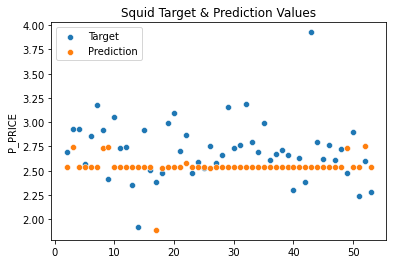

Best Score: 0.16467821676900574
Predict RMSE: 0.35602986741261894


In [94]:
squid_test_features = final_test_squid.drop('P_PRICE',axis=1)
squid_test_target = final_test_squid['P_PRICE']

pred = squid_final.predict(squid_test_features)

sns.scatterplot(range(2,54), y=squid_test_target)
sns.scatterplot(range(2,54), np.exp(pred)-1)

plt.title('Squid Target & Prediction Values')
plt.legend(['Target','Prediction'])
plt.show()

print('Best Score:', np.sqrt(-1 *squid_final.best_score_))
print('Predict RMSE:',(np.sqrt(mean_squared_error(squid_test_target, np.exp(pred)-1))))

### Salmon

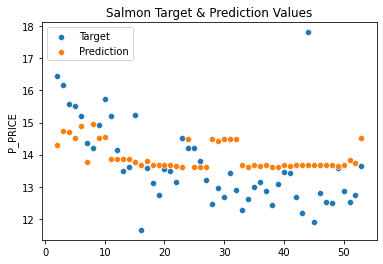

Best Score: 0.0883692850080512
Predict RMSE: 1.175872191903164


In [95]:
salmon_test_features = final_test_salmon.drop('P_PRICE',axis=1)
salmon_test_target = final_test_salmon['P_PRICE']

pred = salmon_final.predict(salmon_test_features)

sns.scatterplot(range(2,54),salmon_test_target)
sns.scatterplot(range(2,54),np.exp(pred)-1)

plt.title('Salmon Target & Prediction Values')
plt.legend(['Target','Prediction'])
plt.show()

print('Best Score:', np.sqrt(-1 *salmon_final.best_score_))
print('Predict RMSE:',(np.sqrt(mean_squared_error(salmon_test_target, np.exp(pred)-1))))

### Whiteleg Shrimp

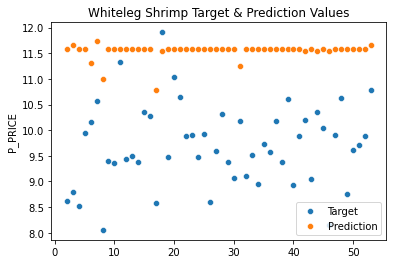

Best Score: 0.06768311339786728
Predict RMSE: 1.9991046712013771


In [96]:
whiteleg_shrimp_test_features = final_test_whiteleg_shrimp.drop('P_PRICE',axis=1)
whiteleg_shrimp_test_target = final_test_whiteleg_shrimp['P_PRICE']

pred = whiteleg_shrimp_final.predict(whiteleg_shrimp_test_features)

sns.scatterplot(range(2,54),whiteleg_shrimp_test_target)
sns.scatterplot(range(2,54),np.exp(pred)-1)

plt.title('Whiteleg Shrimp Target & Prediction Values')
plt.legend(['Target','Prediction'])
plt.show()

print('Best Score:', np.sqrt(-1 *whiteleg_shrimp_final.best_score_))
print('Predict RMSE:',(np.sqrt(mean_squared_error(whiteleg_shrimp_test_target,np.exp(pred)-1))))

# Result

In [97]:
# test data에 맞게 year,week filtering

oil_predict = df_oil[(df_oil['year']==2021) & (df_oil['week']<=26)].groupby(['year','week']).mean()
weather_kr_predict = df_weather_kr[(df_weather_kr['year']==2021) & (df_weather_kr['week']<=26)].groupby(['year','week']).mean()
cpi_predict = df_cpi[(df_cpi['year']==2021) & (df_cpi['week']<=26)].groupby(['year','week']).mean()

In [98]:
# 파생 변수 추가 및 기존 변수들 제거

weather_kr_predict['temp_kr'] = (weather_kr_predict['temperature_kr'] + weather_kr_predict['water_temp_kr'] + weather_kr_predict['wind_kr']) / 3

weather_kr_predict.drop(columns=['temperature_kr', 'wind_kr','water_temp_kr'], axis=1, inplace=True)

cpi_predict['cpi'] = cpi_predict['cpi_fish'] / cpi_predict['cpi_total'] 

cpi_predict.drop(columns=['cpi_fish', 'cpi_total'], axis=1, inplace=True)

## Merge Features

In [99]:
df_predict = oil_predict.copy()

df_predict = pd.merge(df_predict,weather_kr_predict,how='left',on=['year','week'])

In [100]:
df_predict = pd.merge(df_predict,cpi_predict,how='left',on=['year','week'])

### Squid

오징어 모델용 test features들을 생성. -> 최종 결과값 도출

#### squid test features

In [101]:
# 오징어 주요 제조국 및 수출국 filtering

squid_exchange_predict = df_exchange[(df_exchange['CTRY_2'] == '페루') | (df_exchange['CTRY_2'] == '중국') | (df_exchange['CTRY_2'] == '칠레')]
squid_weather_predict = df_weather_with_wf[(df_weather_with_wf['CTRY_1'] == '페루') | (df_weather_with_wf['CTRY_1'] == '중국') | (df_weather_with_wf['CTRY_1'] == '칠레')]

In [102]:
# test data에 맞게 year,week filtering

squid_exchange_predict = squid_exchange_predict[(squid_exchange_predict['year']==2021) & (squid_exchange_predict['week']<=26)]
squid_weather_predict = squid_weather_predict[(squid_weather_predict['year']==2021) & (squid_weather_predict['week']<=26)]

In [103]:
# grouping

squid_exchange_predict = squid_exchange_predict.groupby(['year','week']).mean()
squid_weather_predict = squid_weather_predict.groupby(['year','week']).mean()

In [104]:
# Merge Features

squid_predict = pd.DataFrame()

squid_predict['rain'] = squid_weather_predict['rain']
squid_predict['wind'] = squid_weather_predict['wind']
squid_predict['temperature'] = squid_weather_predict['temperature']
squid_predict['oil'] = df_predict['oil']
squid_predict['exchange'] = squid_exchange_predict
squid_predict['temp_kr'] = df_predict['temp_kr']
squid_predict['cpi'] = df_predict['cpi']

#### Result

In [105]:
squid_pred = squid_final.predict(squid_predict)

pd.DataFrame({'pred':np.exp(squid_pred)-1})

,pred
0,2.738646
1,2.535254
2,2.738646
3,2.535254
4,2.542970
5,2.535254
6,2.743301
7,2.535254
8,2.535254
9,2.535254


## Salmon

연어 모델용 test features들을 생성. -> 최종 결과값 도출

In [106]:
# 연어 주요 제조국 및 수출국 filtering

salmon_exchange_predict = df_exchange[(df_exchange['CTRY_2'] == '노르웨이')]
salmon_weather_predict = df_weather_with_wf[(df_weather_with_wf['CTRY_1'] == '노르웨이')]

In [107]:
# test data에 맞게 year,week filtering

salmon_exchange_predict = salmon_exchange_predict[(salmon_exchange_predict['year']==2021) & (salmon_exchange_predict['week']<=26)]
salmon_weather_predict = salmon_weather_predict[(salmon_weather_predict['year']==2021) & (salmon_weather_predict['week']<=26)]

In [108]:
# grouping

salmon_exchange_predict = salmon_exchange_predict.groupby(['year','week']).mean()
salmon_weather_predict = salmon_weather_predict.groupby(['year','week']).mean()

In [109]:
# Merge Features

salmon_predict = pd.DataFrame()

salmon_predict['rain'] = salmon_weather_predict['rain']
salmon_predict['wind'] = salmon_weather_predict['wind']
salmon_predict['temperature'] = salmon_weather_predict['temperature']
salmon_predict['oil'] = df_predict['oil']
salmon_predict['exchange'] = salmon_exchange_predict
salmon_predict['temp_kr'] = df_predict['temp_kr']
salmon_predict['cpi'] = df_predict['cpi']

#### Result

In [110]:
salmon_pred = salmon_final.predict(salmon_predict)

pd.DataFrame({'pred':np.exp(salmon_pred)-1})

,pred
0,14.910746
1,14.473333
2,14.473333
3,14.473333
4,14.473333
5,14.779717
6,14.432482
7,14.428134
8,14.473333
9,14.473333


## whiteleg_shrimp

흰다리새우 모델용 test features들을 생성. -> 최종 결과값 도출

In [111]:
# 흰다리새우 주요 제조국 및 수출국 filtering

whiteleg_shrimp_exchange_predict = df_exchange[(df_exchange['CTRY_2'] == '태국') | (df_exchange['CTRY_2'] == '베트남')]
whiteleg_shrimp_weather_predict = df_weather_with_wf[(df_weather_with_wf['CTRY_1'] == '태국') | (df_weather_with_wf['CTRY_1'] == '베트남')]

In [112]:
# test data에 맞게 year,week filtering

whiteleg_shrimp_exchange_predict = whiteleg_shrimp_exchange_predict[(whiteleg_shrimp_exchange_predict['year']==2021) & (whiteleg_shrimp_exchange_predict['week']<=26)]
whiteleg_shrimp_weather_predict = whiteleg_shrimp_weather_predict[(whiteleg_shrimp_weather_predict['year']==2021) & (whiteleg_shrimp_weather_predict['week']<=26)]

In [113]:
# grouping

whiteleg_shrimp_exchange_predict = whiteleg_shrimp_exchange_predict.groupby(['year','week']).mean()
whiteleg_shrimp_weather_predict = whiteleg_shrimp_weather_predict.groupby(['year','week']).mean()

In [114]:
# Merge Features

whiteleg_shrimp_predict = pd.DataFrame()

whiteleg_shrimp_predict['rain'] = whiteleg_shrimp_weather_predict['rain']
whiteleg_shrimp_predict['wind'] = whiteleg_shrimp_weather_predict['wind']
whiteleg_shrimp_predict['temperature'] = whiteleg_shrimp_weather_predict['temperature']
whiteleg_shrimp_predict['oil'] = df_predict['oil']
whiteleg_shrimp_predict['exchange'] = whiteleg_shrimp_exchange_predict
whiteleg_shrimp_predict['temp_kr'] = df_predict['temp_kr']
whiteleg_shrimp_predict['cpi'] = df_predict['cpi']

#### Result

In [115]:
whiteleg_shrimp_pred = whiteleg_shrimp_final.predict(whiteleg_shrimp_predict)

pd.DataFrame({'pred': np.exp(whiteleg_shrimp_pred)-1})

,pred
0,11.593063
1,11.593063
2,11.660018
3,11.593063
4,11.593063
5,11.593063
6,11.660018
7,11.660018
8,11.660018
9,11.660018
